In [1]:
# mount drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# install and import
!pip install -q torch==2.8.0+cu126 transformers==4.57.1 datasets==4.0.0 peft==0.17.1 bitsandbytes==0.48.2 accelerate==1.11.0 trl==0.25.0 tqdm==4.67.1 matplotlib==3.10.0

import torch, os, random, json
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, TaskType

In [5]:
# config
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)

seed = 42
random.seed(seed)
torch.manual_seed(seed)

BASE_MODEL = "gpt2-medium"
OUT_DIR = "/content/drive/MyDrive/mini_llm_alignment/sft_qlora"
os.makedirs(OUT_DIR, exist_ok=True)

MAX_LENGTH = 256
BATCH_SIZE = 8
GRAD_ACCUM = 2
EPOCHS = 1
LR = 2e-4

Running on: cuda


In [7]:
dataset = load_dataset("vblagoje/cc_news", split="train[:2%]")
dataset = dataset.shuffle(seed=seed).train_test_split(test_size=0.1, seed=seed)

train_data = dataset["train"]
test_data = dataset["test"]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00005.parquet:   0%|          | 0.00/211M [00:00<?, ?B/s]

plain_text/train-00001-of-00005.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

plain_text/train-00002-of-00005.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

plain_text/train-00003-of-00005.parquet:   0%|          | 0.00/245M [00:00<?, ?B/s]

plain_text/train-00004-of-00005.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/708241 [00:00<?, ? examples/s]

In [8]:
# Tokenizer

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token = tokenizer.eos_token

def preprocess(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False
    )

train_data = train_data.map(preprocess, batched=True, remove_columns=["text"])
test_data = test_data.map(preprocess, batched=True, remove_columns=["text"])

train_data.set_format(type="torch", columns=["input_ids", "attention_mask"])
test_data.set_format(type="torch", columns=["input_ids", "attention_mask"])

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [9]:
# Load GPT-2 Model with QLoRA

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=bnb_cfg,
    device_map="auto"
)

lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM,
    target_modules=["c_attn", "c_proj"]
)

model = get_peft_model(model, lora_cfg)
model.config.pad_token_id = tokenizer.pad_token_id
model.print_trainable_parameters()

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 4,325,376 || all params: 359,148,544 || trainable%: 1.2043


In [11]:
# Trainer Setup
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir=OUT_DIR,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    logging_steps=50,
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    fp16=True,
    report_to="none",
    optim="paged_adamw_8bit",
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=data_collator,
)

In [12]:
# Train and Save

trainer.train()
trainer.save_model(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss


('/content/drive/MyDrive/mini_llm_alignment/sft_qlora/tokenizer_config.json',
 '/content/drive/MyDrive/mini_llm_alignment/sft_qlora/special_tokens_map.json',
 '/content/drive/MyDrive/mini_llm_alignment/sft_qlora/vocab.json',
 '/content/drive/MyDrive/mini_llm_alignment/sft_qlora/merges.txt',
 '/content/drive/MyDrive/mini_llm_alignment/sft_qlora/added_tokens.json',
 '/content/drive/MyDrive/mini_llm_alignment/sft_qlora/tokenizer.json')

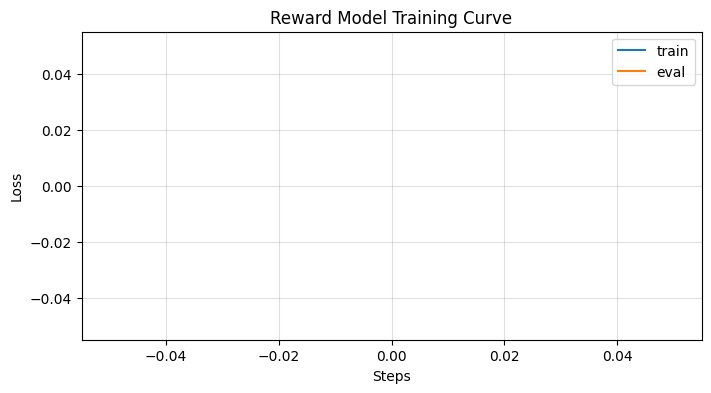

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

steps = [x["step"] for x in logs if "step" in x]
losses = [x["loss"] for x in logs if "loss" in x]
eval_steps = [x["step"] for x in logs if "step" in x]
eval_losses = [x["eval_loss"] for x in logs if "eval_loss" in x]

plt.figure(figsize=(8,4))
plt.plot(steps, losses, label="train")
plt.plot(eval_steps, eval_losses, label="eval")
plt.xlabel("Steps"); plt.ylabel("Loss")
plt.title("Reward Model Training Curve")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

In [14]:
# Evaluate (Perplexity)
import math

eval_results = trainer.evaluate()
print(f"Eval loss: {eval_results['eval_loss']:.4f}")
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Eval loss: 2.7692
Perplexity: 15.95
